## Imports

In [1]:
import numpy as np
import tensorflow as tf
import keras as k
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.signal import butter, filtfilt

# plot defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Using TensorFlow backend.


## Load Data

In [39]:
X_train = np.load("data\X_train_valid.npy")
y_train = np.load("data\y_train_valid.npy")

X_test = np.load("data\X_test.npy")
y_test = np.load("data\y_test.npy")

person_train = np.ravel(np.load("data\person_train_valid.npy"))
person_test = np.ravel(np.load("data\person_test.npy"))

In [3]:
print ('X_train: {}'.format(X_train.shape))
print ('y_train: {}'.format(y_train.shape))

print ('X_test: {}'.format(X_test.shape))
print ('y_test: {}'.format(y_test.shape))

print ('person_train: {}'.format(person_train.shape))
print ('person_test: {}'.format(person_test.shape))

X_train: (2115, 25, 1000)
y_train: (2115,)
X_test: (443, 25, 1000)
y_test: (443,)
person_train: (2115,)
person_test: (443,)


### Data Details

- X
    - shape[0] is the # of trials
    - shape[1] is the # of electrodes
    - shape[2] is the # of time bins
- y
    - shape[0] is action class (see below)


### Class labels

- EEG
    - 1 (Event Type 769 --> 0) : Cue onset left - imagination of movement of the left hand
    - 2 (Event Type 770 --> 1) : Cue onset right - imagination of movement of the right hand
    - 3 (Event Type 771 --> 2) : Cue onset feet - imagination of movement of both feet
    - 4 (Event Type 772 --> 3) : Cue onset tongue - imagination of movement of the tongue
    
- Person
    - 0-9 are different people from whom the EEG were recorded

## Research Questions

1. Optimize the classification accuracy for subject 1. Does it help to train across all subjects?


2. Optimize the classification accuracy across all subjects. How does the classifier do? Do you notice any interesting trends?


3. Evaluate the classification accuracy as a function of time (e.g., does it increase as you have data over longer periods of time? How much time is required to get a reasonable classification accuracy?)

### References

- https://keras.io/preprocessing/sequence/
- https://keras.io/examples/babi_rnn/
- https://keras.io/examples/babi_memnn/

## Helper Functions

### Splitting

In [4]:
def get_train_val_split(data, targets, person_data, val_size=0.2):
    
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    sss.get_n_splits(data, targets)

    X = data
    y = targets
    p = person_data

    for train_index, val_index in sss.split(data, targets):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        person_train, person_val = p[train_index], p[val_index]
        
    return X_train, y_train, X_val, y_val, person_train, person_val

# X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, person_train.shape, person_val.shape)

### Clean Data

In [5]:
def clean_data(X, y):
    # REMOVE EOG DATA
    X = X[:,:-3,:]
    # RESET Y VALUES and ONE HOT ENCODE
    y = y % 769.0
    print('Data cleaned... X shape = {}, y shape = {}'.format(X.shape, y.shape))
    return X, y

# X_train, y_train = clean_data(X_train, y_train)

### Smoothing

In [112]:
def butter_lowpass(cutoff, fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=3):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def smooth_data(data, cutoff=1500, fs=50000, order=3):
    trials, electrodes, time = data.shape
    data_smoothed = np.zeros_like(data)
    for trial in np.arange(trials):
        for electrode in np.arange(electrodes):
            data_smoothed[trial][electrode] = butter_lowpass_filtfilt(data[trial][electrode], cutoff, fs)    
    print('Data smoothed.')
    return data_smoothed

### Scaling

In [7]:
# helper function for standardize_eeg, fits a scaler and transforms the data 
def scale_data(unscaled_data, type='minmax'):
    trials, electrodes, time = unscaled_data.shape
    scaled_data = np.zeros_like(unscaled_data)
    # benefits of being being between 0 and 1, which is useful for embedding
    if type == 'minmax':
        for trial in np.arange(trials):
            scaled_data[trial] = MinMaxScaler().fit_transform(unscaled_data[trial])  
    if type == 'standard':
        for trial in np.arange(trials):
            scaled_data[trial] = StandardScaler().fit_transform(unscaled_data[trial])  
    print('Data scaled via', type)
    return scaled_data

# print('Max and min pre-scaling')
# print(np.max(X_train))
# print(np.min(X_train))

# print('Scaling...')
# X_train_scaled = scale_data(X_train)

# print('Max and min post-scaling')
# print(np.max(X_train_scaled))
# print(np.min(X_train_scaled))

### Targeting individual subjects

In [12]:
def get_train_val_test_for_subject(X_train,
                                   y_train,
                                   X_val, 
                                   y_val,
                                   X_test, 
                                   y_test,
                                   person_train, 
                                   person_val, 
                                   person_test, 
                                   subject=0):
    
    X_train = np.squeeze(X_train[np.argwhere(person_train == subject)])
    y_train = np.squeeze(y_train[np.argwhere(person_train == subject)])
    X_val = np.squeeze(X_val[np.argwhere(person_val == subject)])
    y_val = np.squeeze(y_val[np.argwhere(person_val == subject)])
    X_test = np.squeeze(X_test[np.argwhere(person_test == subject)])
    y_test = np.squeeze(y_test[np.argwhere(person_test == subject)])
    
    print('Data for subject {}'.format(subject))
    print('X_train shape', X_train.shape)
    print('y_train shape', y_train.shape)
    print('X_val shape', X_val.shape)
    print('y_val shape', y_val.shape)
    print('X_test shape', X_test.shape)
    print('y_test shape', y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
#                                                                                             X_val, y_val,
#                                                                                             X_test, y_test,
#                                                                                             person_train, 
#                                                                                             person_val, 
#                                                                                             person_test,
#                                                                                             subject=0)

## Cropping

In [9]:
def crop_data_aug(X, y, crop):
    original_train_X = X
    original_train_y = y

    trials, channel, timesteps = original_train_X.shape
    print("Original Data:", original_train_X.shape, original_train_y.shape)

    crops_per_sample = timesteps - crop
    cropped_train_X = np.zeros((trials*crops_per_sample, channel, crop))
    cropped_train_y = np.zeros(trials*crops_per_sample)

    for n in np.arange(trials):
        crop_count = 0
        for t in np.arange(crops_per_sample):
            idx = n * crops_per_sample + crop_count
            cropped_train_X[idx] = original_train_X[n, :, t:t+crop]
            cropped_train_y[idx] = original_train_y[n]
            crop_count = crop_count + 1

    print("Cropped Data:", cropped_train_X.shape, cropped_train_y.shape)
    
    return cropped_train_X, cropped_train_y

### Misc

In [10]:
def smooth_then_scale(data, type='minmax'):
    return scale_data(smooth_data(data), type)

def scale_then_smooth(data, type='minmax'):
    return smooth_data(scale_data(data, type))

### Plotting History

In [65]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Preprocessing

In [40]:
X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)

X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

# Targting one specific subject
X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
                                                                                            X_val, y_val,
                                                                                            X_test, y_test,
                                                                                            person_train, 
                                                                                            person_val, 
                                                                                            person_test,
                                                                                            subject=0)

# X_train = scale_then_smooth(X_train)
# X_val = scale_then_smooth(X_val)
# X_test = scale_then_smooth(X_test)

Data cleaned... X shape = (1692, 22, 1000), y shape = (1692,)
Data cleaned... X shape = (423, 22, 1000), y shape = (423,)
Data cleaned... X shape = (443, 22, 1000), y shape = (443,)
Data for subject 0
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (47, 22, 1000)
y_val shape (47,)
X_test shape (50, 22, 1000)
y_test shape (50,)


In [41]:
cropped_train_X_0, cropped_train_y_0 = crop_data_aug(X_train_0, y_train_0, 950)
cropped_val_X_0, cropped_val_y_0 = crop_data_aug(X_val_0, y_val_0, 950)
cropped_test_X_0, cropped_test_y_0 = crop_data_aug(X_test_0, y_test_0, 950)

Original Data: (190, 22, 1000) (190,)
Cropped Data: (9500, 22, 950) (9500,)
Original Data: (47, 22, 1000) (47,)
Cropped Data: (2350, 22, 950) (2350,)
Original Data: (50, 22, 1000) (50,)
Cropped Data: (2500, 22, 950) (2500,)


# Comparing Performance as a Function of Time

In [106]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Permute, Flatten, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [110]:
# simple early stopping
es = EarlyStopping(monitor='val_acc', mode='max', min_delta=.005, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [115]:
time_stops = [i*100 for i in np.arange(1,11)]

In [116]:
time_stops

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

Testing max time of 100 timesteps
train_x_ts shape (1692, 22, 100)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 46s 27ms/step - loss: 1.5858 - acc: 0.2423 - val_loss: 1.3924 - val_acc: 0.2931
Epoch 2/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.3766 - acc: 0.3327 - val_loss: 1.3773 - val_acc: 0.3333
Epoch 3/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.2906 - acc: 0.3901 - val_loss: 1.3658 - val_acc: 0.3215
Epoch 4/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.2181 - acc: 0.4498 - val_loss: 1.3584 - val_acc: 0.3310A: 1s - l
Epoch 5/50
1692/1692 [==============================] - 4s 3ms/step - loss: 1.2102 - acc: 0.4498 - val_loss: 1.3666 - val_acc: 0.3073
Epoch 6/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.1689 - acc: 0.4787 - val_loss: 1.3677 - val_acc: 0.3333
Epoch 7/50
1692/1692 [==============================] - 5s 3ms/step - l

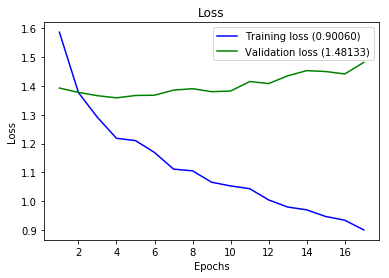

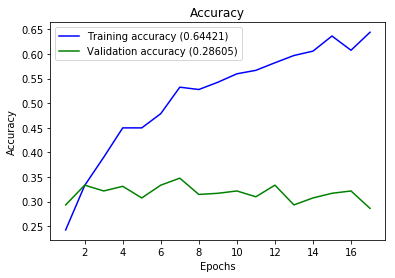

Testing max time of 200 timesteps
train_x_ts shape (1692, 22, 200)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 45s 26ms/step - loss: 1.5584 - acc: 0.2665 - val_loss: 1.3853 - val_acc: 0.3262
Epoch 2/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.3443 - acc: 0.3658 - val_loss: 1.3475 - val_acc: 0.3333
Epoch 3/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.2569 - acc: 0.4285 - val_loss: 1.3413 - val_acc: 0.3475
Epoch 4/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.2068 - acc: 0.4639 - val_loss: 1.3380 - val_acc: 0.3593
Epoch 5/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.1782 - acc: 0.4787 - val_loss: 1.3524 - val_acc: 0.3475
Epoch 6/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.1295 - acc: 0.5219 - val_loss: 1.3544 - val_acc: 0.3428
Epoch 7/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.10

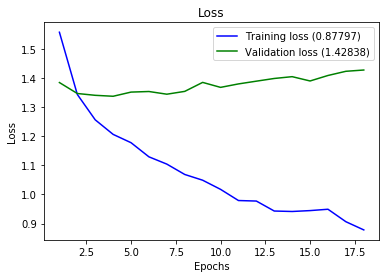

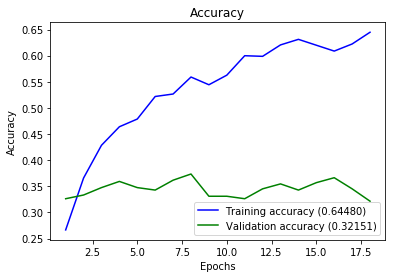

Testing max time of 300 timesteps
train_x_ts shape (1692, 22, 300)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 45s 27ms/step - loss: 1.5704 - acc: 0.2754 - val_loss: 1.4300 - val_acc: 0.2908
Epoch 2/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.3701 - acc: 0.3593 - val_loss: 1.3993 - val_acc: 0.3310
Epoch 3/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.2547 - acc: 0.4078 - val_loss: 1.3894 - val_acc: 0.3333
Epoch 4/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.2042 - acc: 0.4876 - val_loss: 1.3754 - val_acc: 0.3877
Epoch 5/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.1379 - acc: 0.5083 - val_loss: 1.3772 - val_acc: 0.3286
Epoch 6/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.1086 - acc: 0.5455 - val_loss: 1.3630 - val_acc: 0.3617
Epoch 7/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.06

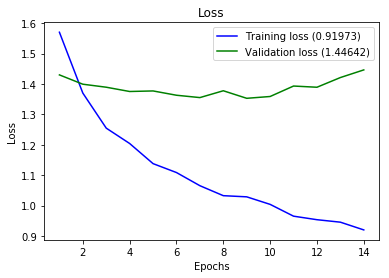

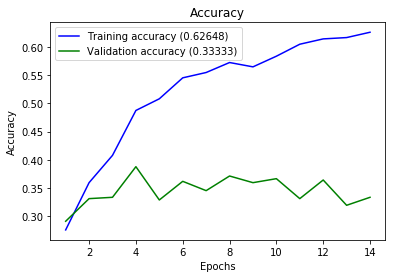

Testing max time of 400 timesteps
train_x_ts shape (1692, 22, 400)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 49s 29ms/step - loss: 1.5912 - acc: 0.2453 - val_loss: 1.3989 - val_acc: 0.2861
Epoch 2/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.3034 - acc: 0.3960 - val_loss: 1.3872 - val_acc: 0.3310
Epoch 3/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.2237 - acc: 0.4427 - val_loss: 1.3690 - val_acc: 0.3522
Epoch 4/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.1727 - acc: 0.4864 - val_loss: 1.3897 - val_acc: 0.3215
Epoch 5/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.1374 - acc: 0.5118 - val_loss: 1.3876 - val_acc: 0.3310
Epoch 6/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.0930 - acc: 0.5426 - val_loss: 1.3939 - val_acc: 0.3357
Epoch 7/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.05

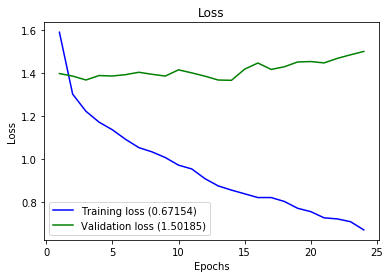

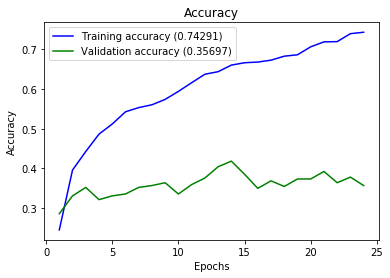

Testing max time of 500 timesteps
train_x_ts shape (1692, 22, 500)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 50s 30ms/step - loss: 1.5598 - acc: 0.2766 - val_loss: 1.4117 - val_acc: 0.2955
Epoch 2/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.3523 - acc: 0.3777 - val_loss: 1.3804 - val_acc: 0.3310
Epoch 3/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.2324 - acc: 0.4586 - val_loss: 1.3818 - val_acc: 0.3168
Epoch 4/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.1760 - acc: 0.4734 - val_loss: 1.3647 - val_acc: 0.3593
Epoch 5/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.0887 - acc: 0.5325 - val_loss: 1.3877 - val_acc: 0.3522
Epoch 6/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.0599 - acc: 0.5644 - val_loss: 1.3859 - val_acc: 0.3381
Epoch 7/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.01

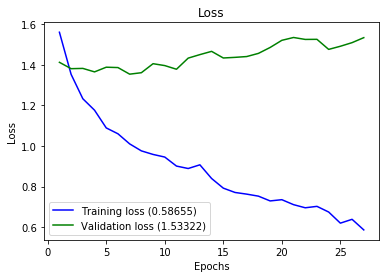

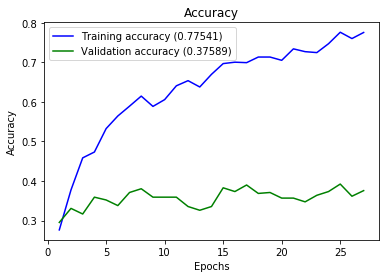

Testing max time of 600 timesteps
train_x_ts shape (1692, 22, 600)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 51s 30ms/step - loss: 1.5700 - acc: 0.2748 - val_loss: 1.3985 - val_acc: 0.3144
Epoch 2/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.3171 - acc: 0.3859 - val_loss: 1.3954 - val_acc: 0.3168
Epoch 3/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.2173 - acc: 0.4427 - val_loss: 1.3928 - val_acc: 0.3239
Epoch 4/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.1385 - acc: 0.5041 - val_loss: 1.4062 - val_acc: 0.3191
Epoch 5/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.1146 - acc: 0.5095 - val_loss: 1.4142 - val_acc: 0.3262
Epoch 6/50
1692/1692 [==============================] - 5s 3ms/step - loss: 1.0510 - acc: 0.5621 - val_loss: 1.3975 - val_acc: 0.3452
Epoch 7/50
1692/1692 [==============================] - 6s 4ms/step - loss: 1.03

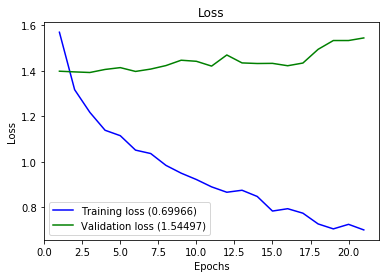

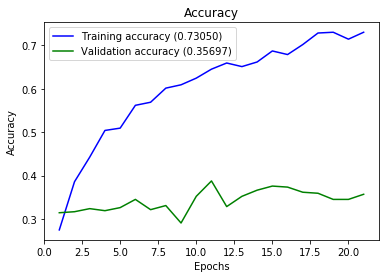

Testing max time of 700 timesteps
train_x_ts shape (1692, 22, 700)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 53s 31ms/step - loss: 1.6082 - acc: 0.2671 - val_loss: 1.4231 - val_acc: 0.2955
Epoch 2/50
1692/1692 [==============================] - 6s 4ms/step - loss: 1.3465 - acc: 0.3729 - val_loss: 1.3907 - val_acc: 0.3097
Epoch 3/50
1692/1692 [==============================] - 6s 4ms/step - loss: 1.2163 - acc: 0.4639 - val_loss: 1.3715 - val_acc: 0.3475 - acc: 0
Epoch 4/50
1692/1692 [==============================] - 6s 4ms/step - loss: 1.1284 - acc: 0.5148 - val_loss: 1.3819 - val_acc: 0.36641s - los
Epoch 5/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.0985 - acc: 0.5242 - val_loss: 1.3792 - val_acc: 0.3688
Epoch 6/50
1692/1692 [==============================] - 6s 3ms/step - loss: 1.0474 - acc: 0.5674 - val_loss: 1.3956 - val_acc: 0.3310
Epoch 7/50
1692/1692 [==============================] - 6s 4ms/

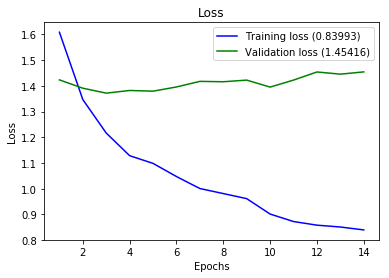

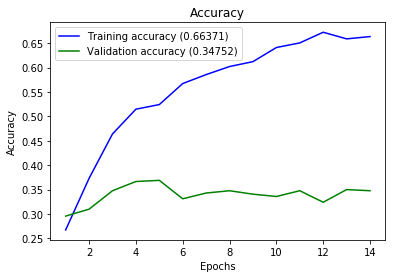

Testing max time of 800 timesteps
train_x_ts shape (1692, 22, 800)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 59s 35ms/step - loss: 1.6185 - acc: 0.2518 - val_loss: 1.4040 - val_acc: 0.3286
Epoch 2/50
1692/1692 [==============================] - 14s 8ms/step - loss: 1.3423 - acc: 0.3806 - val_loss: 1.3874 - val_acc: 0.3381
Epoch 3/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.2326 - acc: 0.4480 - val_loss: 1.3775 - val_acc: 0.3381
Epoch 4/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.1637 - acc: 0.4876 - val_loss: 1.3476 - val_acc: 0.3499
Epoch 5/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.0965 - acc: 0.5236 - val_loss: 1.3385 - val_acc: 0.3617
Epoch 6/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.0464 - acc: 0.5591 - val_loss: 1.3611 - val_acc: 0.3452
Epoch 7/50
1692/1692 [==============================] - 13s 8ms/step - loss

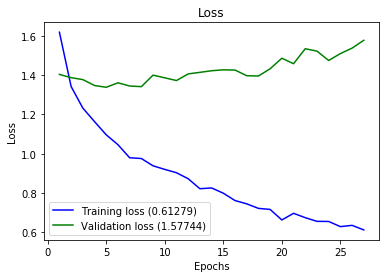

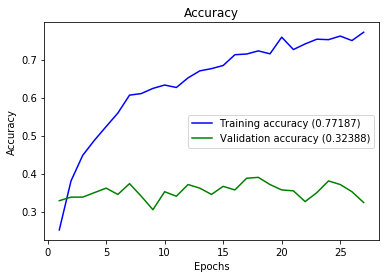

Testing max time of 900 timesteps
train_x_ts shape (1692, 22, 900)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 58s 34ms/step - loss: 1.5941 - acc: 0.2470 - val_loss: 1.4243 - val_acc: 0.2979
Epoch 2/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.3428 - acc: 0.3623 - val_loss: 1.4099 - val_acc: 0.3097
Epoch 3/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.2208 - acc: 0.4539 - val_loss: 1.3827 - val_acc: 0.3357
Epoch 4/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.1491 - acc: 0.5130 - val_loss: 1.3730 - val_acc: 0.3452
Epoch 5/50
1692/1692 [==============================] - 14s 8ms/step - loss: 1.1026 - acc: 0.5319 - val_loss: 1.4030 - val_acc: 0.3475
Epoch 6/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.0839 - acc: 0.5343 - val_loss: 1.3951 - val_acc: 0.326263 - acc: 0
Epoch 7/50
1692/1692 [==============================] - 13s 8ms/

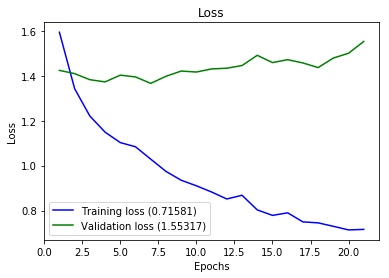

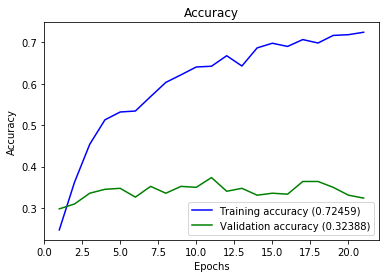

Testing max time of 1000 timesteps
train_x_ts shape (1692, 22, 1000)
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 58s 34ms/step - loss: 1.5960 - acc: 0.2654 - val_loss: 1.4311 - val_acc: 0.2553
Epoch 2/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.3345 - acc: 0.3818 - val_loss: 1.4272 - val_acc: 0.2884
Epoch 3/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.2187 - acc: 0.4545 - val_loss: 1.4183 - val_acc: 0.3121
Epoch 4/50
1692/1692 [==============================] - 14s 8ms/step - loss: 1.1567 - acc: 0.5006 - val_loss: 1.4104 - val_acc: 0.3168
Epoch 5/50
1692/1692 [==============================] - 13s 7ms/step - loss: 1.1112 - acc: 0.5183 - val_loss: 1.4080 - val_acc: 0.3262
Epoch 6/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.0553 - acc: 0.5626 - val_loss: 1.4721 - val_acc: 0.3357
Epoch 7/50
1692/1692 [==============================] - 14s 8ms/step - lo

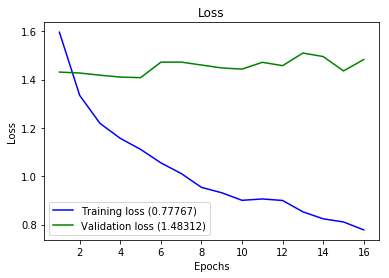

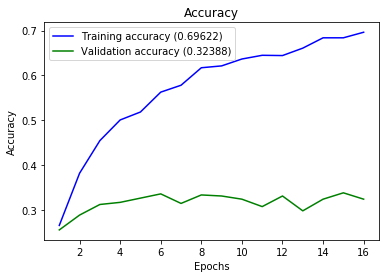

{100: [1.3999103654857146, 0.31602708830521287],
 200: [1.3562679419937307, 0.3498871334519397],
 300: [1.3740299627958517, 0.3273137699535146],
 400: [1.4441889231145786, 0.3476297970415507],
 500: [1.451978860805589, 0.35214446972778096],
 600: [1.4418624434998557, 0.3386004516690902],
 700: [1.3776128528887746, 0.3137697517602761],
 800: [1.4365960849327104, 0.3972911966573573],
 900: [1.4132051817719609, 0.3431151243553205],
 1000: [1.4569194814690618, 0.2799097066808231]}

In [121]:
train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test

trials, electrodes, timesteps = train_x.shape

time_stops = [i*100 for i in np.arange(1,11)]

test_scores = {}

for stop in time_stops:
    
    print('Testing max time of {} timesteps'.format(stop))
    
    train_x_ts = train_x[:,:,:stop] 
    val_x_ts = val_x[:,:,:stop] 
    test_x_ts = test_x[:,:,:stop] 
    
    print('train_x_ts shape', train_x_ts.shape)
    
    # create model layers
    model = Sequential([
        LSTM(100, return_sequences=False, input_shape=(electrodes, stop)),
        Dropout(0.5),
        Dense(4, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_x_ts, train_y, batch_size=16, epochs=50, validation_data=(val_x_ts, val_y), callbacks=[es])
    
    test_scores[stop] = model.evaluate(test_x_ts, test_y, batch_size=16)

    plot_history(history)
    
test_scores

No handles with labels found to put in legend.


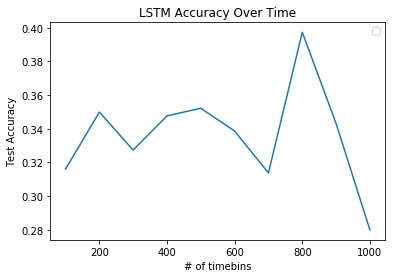

No handles with labels found to put in legend.


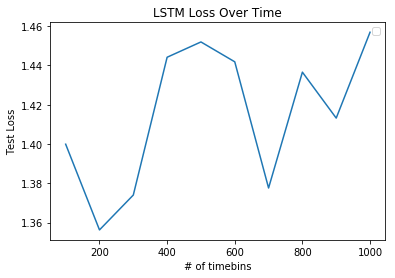

In [133]:
timesteps = list(test_scores)
loss = np.array(list(test_scores.values()))[:,0]
acc = np.array(list(test_scores.values()))[:,1]

plt.plot(timesteps, acc)
plt.title('LSTM Accuracy Over Time')
plt.xlabel('# of timebins')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

plt.plot(timesteps, loss)
plt.title('LSTM Loss Over Time')
plt.xlabel('# of timebins')
plt.ylabel('Test Loss')
plt.legend()
plt.show()

In [136]:
np.corrcoef(timesteps, acc)

array([[ 1.        , -0.08214812],
       [-0.08214812,  1.        ]])

In [137]:
np.corrcoef(timesteps, loss)

array([[1.        , 0.51156302],
       [0.51156302, 1.        ]])

# Model Comparisons for Subject 1

### Single Level LSTM for Subject 1 without Cropping

Train on 190 samples, validate on 47 samples
Epoch 1/50
190/190 [==============================] - 23s 121ms/step - loss: 1.7007 - acc: 0.2368 - val_loss: 1.5250 - val_acc: 0.2979
Epoch 2/50
190/190 [==============================] - 1s 8ms/step - loss: 1.1947 - acc: 0.4632 - val_loss: 1.4480 - val_acc: 0.2553
Epoch 3/50
190/190 [==============================] - 1s 7ms/step - loss: 0.9512 - acc: 0.6421 - val_loss: 1.4256 - val_acc: 0.2553
Epoch 4/50
190/190 [==============================] - 1s 7ms/step - loss: 0.8548 - acc: 0.6737 - val_loss: 1.4027 - val_acc: 0.3191
Epoch 5/50
190/190 [==============================] - 1s 6ms/step - loss: 0.7418 - acc: 0.7421 - val_loss: 1.4446 - val_acc: 0.3830
Epoch 6/50
190/190 [==============================] - 1s 6ms/step - loss: 0.6764 - acc: 0.7789 - val_loss: 1.4436 - val_acc: 0.2340
Epoch 7/50
190/190 [==============================] - 2s 9ms/step - loss: 0.5909 - acc: 0.8368 - val_loss: 1.4029 - val_acc: 0.2979
Epoch 8/50
190/190 [========

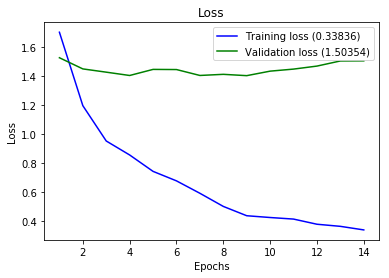

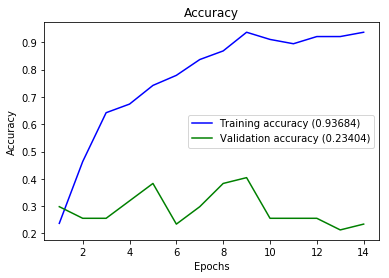

In [92]:
train_x, train_y = X_train_0, y_train_0
val_x, val_y = X_val_0, y_val_0
test_x, test_y = X_test_0, y_test_0 

trials, electrodes, timesteps = train_x.shape

# create model layers
model = Sequential([
    LSTM(100, return_sequences=False, input_shape=(electrodes, timesteps)),
    Dropout(0.5),
    Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y), )
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

plot_history(history)

### Single Level GRU for Subject 1 without Cropping

Train on 190 samples, validate on 47 samples
Epoch 1/50
190/190 [==============================] - 23s 121ms/step - loss: 2.3249 - acc: 0.2579 - val_loss: 1.6418 - val_acc: 0.2340
Epoch 2/50
190/190 [==============================] - 1s 4ms/step - loss: 1.4252 - acc: 0.4211 - val_loss: 1.6403 - val_acc: 0.3404
Epoch 3/50
190/190 [==============================] - 1s 4ms/step - loss: 1.2836 - acc: 0.4737 - val_loss: 1.6354 - val_acc: 0.2979
Epoch 4/50
190/190 [==============================] - 1s 3ms/step - loss: 0.9590 - acc: 0.6053 - val_loss: 1.5831 - val_acc: 0.3404
Epoch 5/50
190/190 [==============================] - 1s 3ms/step - loss: 0.7863 - acc: 0.7263 - val_loss: 1.6061 - val_acc: 0.3191
Epoch 6/50
190/190 [==============================] - 1s 4ms/step - loss: 0.6842 - acc: 0.7263 - val_loss: 1.6157 - val_acc: 0.3404
Epoch 7/50
50/50 [==============================] - 0s 1ms/step
[1.7485962295532227, 0.26]


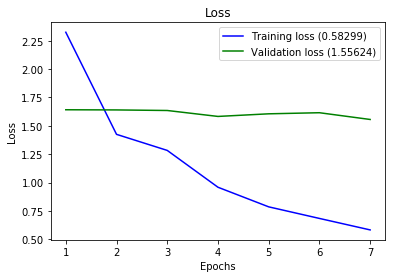

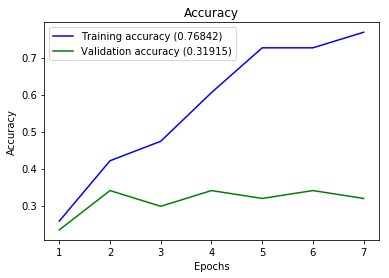

In [93]:
train_x, train_y = X_train_0, y_train_0
val_x, val_y = X_val_0, y_val_0
test_x, test_y = X_test_0, y_test_0 

trials, electrodes, timesteps = train_x.shape

# create model layers
model = Sequential([
    GRU(100, return_sequences=False, input_shape=(electrodes, timesteps)),
    Dropout(0.5),
    Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y), callbacks=[es])
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

plot_history(history)

### Single Level LSTM for Subject 1 with Cropping

Train on 9500 samples, validate on 2350 samples
Epoch 1/20
9500/9500 [==============================] - 97s 10ms/step - loss: 1.2692 - acc: 0.4275 - val_loss: 1.4361 - val_acc: 0.3098
Epoch 2/20
9500/9500 [==============================] - 69s 7ms/step - loss: 0.9867 - acc: 0.5933 - val_loss: 1.5595 - val_acc: 0.2557
Epoch 3/20
9500/9500 [==============================] - 71s 7ms/step - loss: 0.8738 - acc: 0.6496 - val_loss: 1.5687 - val_acc: 0.2915
Epoch 4/20
9500/9500 [==============================] - 72s 8ms/step - loss: 0.7841 - acc: 0.6937 - val_loss: 1.6189 - val_acc: 0.2923
Epoch 5/20
9500/9500 [==============================] - 71s 7ms/step - loss: 0.7097 - acc: 0.7232 - val_loss: 1.6519 - val_acc: 0.2996
Epoch 6/20
2500/2500 [==============================] - 5s 2ms/step
[1.4350271968841553, 0.3224]


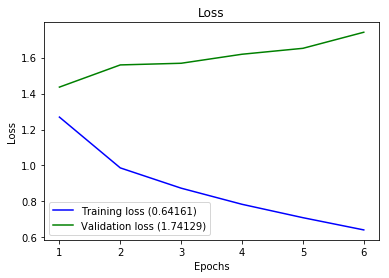

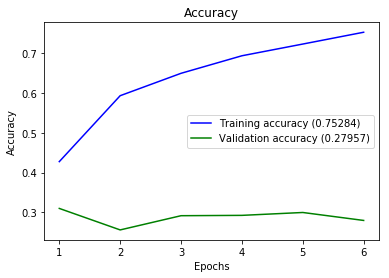

In [94]:
train_x, train_y = cropped_train_X_0, cropped_train_y_0
val_x, val_y = cropped_val_X_0, cropped_val_y_0
test_x, test_y = cropped_test_X_0, cropped_test_y_0 

trials, electrodes, timesteps = train_x.shape

# create model layers
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(electrodes, timesteps)),
    Dropout(0.5),
    Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=16, epochs=20, validation_data=(val_x, val_y), callbacks=[es])
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

plot_history(history)

So cropping seems to make the model overfit more easily, while increasing training time 50x. Since it only gives a modest boost in test accuracy, I'm going to forgo cropping for the remainder of the analysis of params and then at the end add it back in. 

### Single Level GRU for Subject 1 with Cropping

Train on 9500 samples, validate on 2350 samples
Epoch 1/20
9500/9500 [==============================] - 63s 7ms/step - loss: 1.4493 - acc: 0.4206 - val_loss: 1.5061 - val_acc: 0.2851
Epoch 2/20
9500/9500 [==============================] - 42s 4ms/step - loss: 1.0597 - acc: 0.5559 - val_loss: 1.5114 - val_acc: 0.3055
Epoch 3/20
9500/9500 [==============================] - 43s 4ms/step - loss: 0.9561 - acc: 0.6088 - val_loss: 1.5190 - val_acc: 0.3149
Epoch 4/20
9500/9500 [==============================] - 38s 4ms/step - loss: 0.8997 - acc: 0.6391 - val_loss: 1.6194 - val_acc: 0.2894
Epoch 5/20
9500/9500 [==============================] - 38s 4ms/step - loss: 0.8606 - acc: 0.6558 - val_loss: 1.6656 - val_acc: 0.2774
Epoch 6/20
9500/9500 [==============================] - 37s 4ms/step - loss: 0.8195 - acc: 0.6734 - val_loss: 1.6337 - val_acc: 0.2983
Epoch 7/20
9500/9500 [==============================] - 35s 4ms/step - loss: 0.7775 - acc: 0.6905 - val_loss: 1.7020 - val_acc: 0.3021
Epoch 8

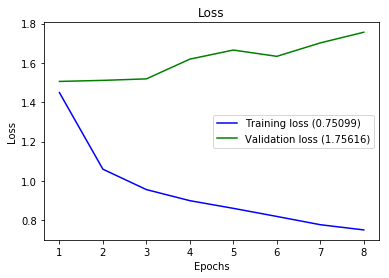

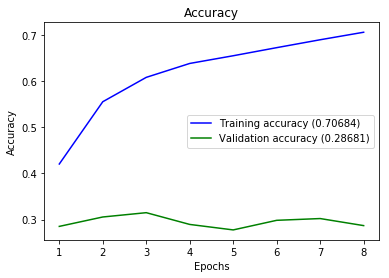

In [95]:
train_x, train_y = cropped_train_X_0, cropped_train_y_0
val_x, val_y = cropped_val_X_0, cropped_val_y_0
test_x, test_y = cropped_test_X_0, cropped_test_y_0 

trials, electrodes, timesteps = train_x.shape

# create model layers
model = Sequential([
    GRU(50, return_sequences=False, input_shape=(electrodes, timesteps)),
    Dropout(0.5),
    Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=16, epochs=20, validation_data=(val_x, val_y), callbacks=[es])
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

plot_history(history)

### Single LSTM comparison of data smoothing/scaling for Subject 1

Transformed by <function scale_data at 0x0000029C3F0EA7B8>, scaling = minmax
Data scaled via minmax
Data scaled via minmax
Data scaled via minmax
Train on 190 samples, validate on 47 samples
Epoch 1/10
190/190 [==============================] - 31s 166ms/step - loss: 1.6127 - acc: 0.1842 - val_loss: 1.4375 - val_acc: 0.3191
Epoch 2/10
190/190 [==============================] - 2s 10ms/step - loss: 1.4413 - acc: 0.2684 - val_loss: 1.4003 - val_acc: 0.4043
Epoch 3/10
190/190 [==============================] - 1s 8ms/step - loss: 1.3316 - acc: 0.3316 - val_loss: 1.3850 - val_acc: 0.3617
Epoch 4/10
190/190 [==============================] - 1s 6ms/step - loss: 1.3259 - acc: 0.3579 - val_loss: 1.3799 - val_acc: 0.3404
Epoch 5/10
190/190 [==============================] - 1s 6ms/step - loss: 1.2475 - acc: 0.4579 - val_loss: 1.4013 - val_acc: 0.3830
Epoch 6/10
190/190 [==============================] - 1s 6ms/step - loss: 1.1968 - acc: 0.4789 - val_loss: 1.3872 - val_acc: 0.3830
Epoch 7/10
47

190/190 [==============================] - 1s 8ms/step - loss: 0.1112 - acc: 0.9947 - val_loss: 1.5999 - val_acc: 0.3404
Epoch 9/10
190/190 [==============================] - 1s 7ms/step - loss: 0.0797 - acc: 1.0000 - val_loss: 1.6311 - val_acc: 0.3191
Epoch 10/10
47/47 [==============================] - 0s 1ms/step
Transformed by <function scale_then_smooth at 0x0000029C3F0EA598>, scaling = minmax
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Train on 190 samples, validate on 47 samples
Epoch 1/10
190/190 [==============================] - 34s 178ms/step - loss: 1.5671 - acc: 0.2368 - val_loss: 1.5465 - val_acc: 0.2553
Epoch 2/10
190/190 [==============================] - 2s 9ms/step - loss: 1.4242 - acc: 0.2684 - val_loss: 1.5056 - val_acc: 0.1915
Epoch 3/10
190/190 [==============================] - 2s 9ms/step - loss: 1.3752 - acc: 0.2737 - val_loss: 1.5222 - val_acc: 0.2340
Epoch 4/10
190/190 [====================

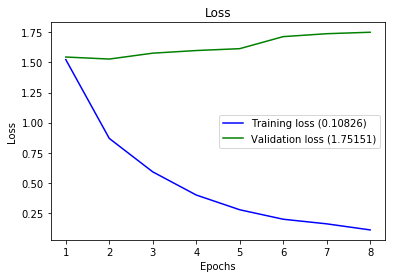

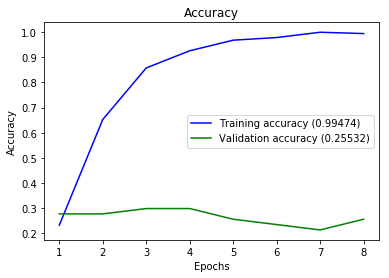

In [102]:
train_x, train_y = X_train_0, y_train_0
val_x, val_y = X_val_0, y_val_0
test_x, test_y = X_test_0, y_test_0 

trials, electrodes, timesteps = train_x.shape

functions = [scale_data, smooth_data, smooth_then_scale, scale_then_smooth]
scalings = ['minmax', 'standard']

best_acc = 0
best_f = None
best_scaling = None

for f in functions:
    for scaling in scalings:       
        print('Transformed by {}, scaling = {}'.format(f, scaling))
    
        try:
            train = f(train_x, scaling)
            val = f(val_x, scaling)
            test = f(test_x, scaling)
        except:
            train = f(train_x)
            val = f(val_x)
            test = f(test_x)

        # create model layers
        model = Sequential([
            LSTM(100, return_sequences=False, input_shape=(electrodes, timesteps)),
            Dropout(0.5),
            Dense(4, activation=tf.nn.softmax)
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(train, train_y, batch_size=16, epochs=10, validation_data=(val_x, val_y), callbacks=[es])
        loss, acc = model.evaluate(val_x, val_y, batch_size=16)
        
        if acc > best_acc:
            best_f = f
            best_scaling = scaling
            best_optim = optim
            best_units = units
            best_state = state
            best_acc = acc
    
print('Best acc = {}, fn = {}, scaling = {}'
      .format(best_acc, best_f, best_scaling))

print('Testing best hyperparams...')
    
try:
    train = f(train_x, scaling)
    val = f(val_x, scaling)
    test = f(test_x, scaling)
except:
    train = f(train_x)
    val = f(val_x)
    test = f(test_x)

# create model layers
model = Sequential([
    LSTM(100, return_sequences=False, input_shape=(electrodes, timesteps)),
    Dropout(0.5),
    Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train, train_y, batch_size=16, epochs=20, validation_data=(val_x, val_y), callbacks=[es])
loss, acc = model.evaluate(val_x, val_y, batch_size=16)

plot_history(history)

### 2 ConvID + 2 GRU

Train on 190 samples, validate on 47 samples
Epoch 1/50
190/190 [==============================] - 45s 235ms/step - loss: 1.4276 - acc: 0.3000 - val_loss: 1.4157 - val_acc: 0.2979
Epoch 2/50
190/190 [==============================] - 9s 48ms/step - loss: 1.4554 - acc: 0.2789 - val_loss: 1.4871 - val_acc: 0.1915
Epoch 3/50
190/190 [==============================] - 10s 50ms/step - loss: 1.3518 - acc: 0.3368 - val_loss: 1.3476 - val_acc: 0.3191
Epoch 4/50
190/190 [==============================] - 9s 48ms/step - loss: 1.3216 - acc: 0.3737 - val_loss: 1.3546 - val_acc: 0.3404
Epoch 5/50
190/190 [==============================] - 9s 48ms/step - loss: 1.3251 - acc: 0.3526 - val_loss: 1.3719 - val_acc: 0.2766
Epoch 6/50
190/190 [==============================] - 10s 51ms/step - loss: 1.2274 - acc: 0.4579 - val_loss: 1.4232 - val_acc: 0.2979
Epoch 7/50
190/190 [==============================] - 9s 47ms/step - loss: 1.2172 - acc: 0.4684 - val_loss: 1.4810 - val_acc: 0.2128
Epoch 8/50
190/190 [

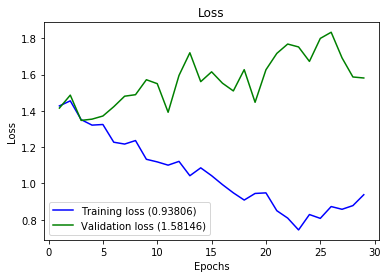

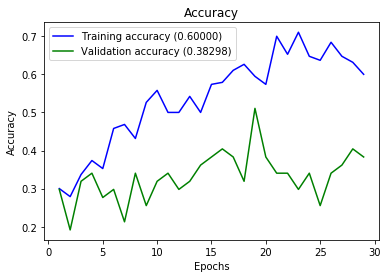

In [111]:
train_x, train_y = X_train_0, y_train_0
val_x, val_y = X_val_0, y_val_0
test_x, test_y = X_test_0, y_test_0 

trials, electrodes, timesteps = train_x.shape

model = Sequential()
model.add(Permute((2, 1), input_shape=(22, 1000)))

model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
model.add(Dropout(0.4))
model.add(Conv1D(filters = 64, kernel_size = 25, activation = 'elu'))
model.add(Dropout(0.4))

model.add(Permute((2, 1)))

# GRU layers
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))

# Dense layers
model.add(Flatten())
model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y), callbacks=[es])
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

plot_history(history)

### Stacked LSTM hyperopt for Subject 1

In [59]:
train_x, train_y = X_train_0, y_train_0
val_x, val_y = X_val_0, y_val_0
test_x, test_y = X_test_0, y_test_0 

trials, electrodes, timesteps = train_x.shape

# functions = [scale_then_smooth]
# scalings = ['minmax']
# optims = ['Adamax', 'RMSprop']
# num_units = [25, 50, 75]
# stateful = [True, False]

functions = [scale_then_smooth]
scalings = ['minmax']
optims = ['RMSprop']
num_units = [50]
stateful = [True]

best_acc = 0
best_optim = None
best_units = None
best_state = None

batch_size = 1

for state in stateful:
    for optim in optims:
        for scaling in scalings:
            for f in functions:
                for units in num_units:
                    print('Data transformed by {}, scaling = {}, optim = {}, num_units = {}, stateful = {}'
                          .format(f, scaling, optim, units, state))

                    try:
                        train = f(train_x, scaling)
                        val = f(val_x, scaling)
                        test = f(test_x, scaling)
                    except:
                        train = f(train_x)
                        val = f(val_x)
                        test = f(test_x)

                    model = Sequential()
                    model.add(LSTM(units, return_sequences=True, stateful=state,
                                   batch_input_shape=(batch_size, electrodes, timesteps)))  
                    model.add(LSTM(units, return_sequences=True, stateful=state)) 
                    model.add(LSTM(units, stateful=state))
                    model.add(Dense(4, activation='softmax'))

                    model.compile(loss='sparse_categorical_crossentropy',
                                  optimizer='rmsprop',
                                  metrics=['accuracy'])
                    
                    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=10, validation_data=(val_x, val_y), callbacks=[es])                    
                    loss, acc = model.evaluate(val_x, val_y, batch_size=batch_size)
                    
                    print(acc)

                    if acc > best_acc:
                        best_f = f
                        best_scaling = scaling
                        best_optim = optim
                        best_units = units
                        best_state = state
                        best_acc = acc

print('Best acc = {}, fn = {}, scaling = {}, optim = {}, num_units = {}, state = {}'
      .format(best_acc, best_f, best_scaling, best_optim, best_units, best_state))

print('Testing best hyperparams...')

try:
    train = best_f(train_x, best_scaling)
    val = best_f(val_x, best_scaling)
    test = best_f(test_x, best_scaling)
except:
    train = best_f(train_x)
    val = best_f(val_x)
    test = best_f(test_x)

# expected input data shape: (batch_size, electrodes, time_steps)
model = Sequential()
model.add(LSTM(units, return_sequences=True, stateful=best_state,
               batch_input_shape=(batch_size, electrodes, timesteps)))  
model.add(Dropout(0.5))
model.add(LSTM(units, return_sequences=True, stateful=best_state)) 
model.add(Dropout(0.5))
model.add(LSTM(units, stateful=best_state))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_optim,
              metrics=['accuracy'])

model.fit(train_x, train_y, batch_size=batch_size, epochs=10)
loss, acc = model.evaluate(test_x, test_y, batch_size=batch_size)
print('acc: ', acc)

Data transformed by <function scale_then_smooth at 0x0000029C3F0EA598>, scaling = minmax, optim = RMSprop, num_units = 50, stateful = True
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Train on 190 samples, validate on 47 samples
Epoch 1/10
190/190 [==============================] - 25s 132ms/step - loss: 1.3873 - acc: 0.2737 - val_loss: 1.3798 - val_acc: 0.2979
Epoch 2/10
190/190 [==============================] - 9s 47ms/step - loss: 1.0074 - acc: 0.6316 - val_loss: 1.5744 - val_acc: 0.2340
Epoch 3/10
190/190 [==============================] - 9s 45ms/step - loss: 0.6311 - acc: 0.7579 - val_loss: 1.6372 - val_acc: 0.3404
Epoch 4/10
190/190 [==============================] - 9s 46ms/step - loss: 0.2803 - acc: 0.9105 - val_loss: 2.0586 - val_acc: 0.3404
Epoch 5/10
190/190 [==============================] - 9s 45ms/step - loss: 0.1410 - acc: 0.9421 - val_loss: 2.6440 - val_acc: 0.3191
Epoch 6/10
190/190 [===============

### Stacked GRU hyperopt for Subject 1

In [138]:
train_x, train_y = X_train_0, y_train_0
val_x, val_y = X_val_0, y_val_0
test_x, test_y = X_test_0, y_test_0 

trials, electrodes, timesteps = train_x.shape

# functions = [scale_then_smooth]
# scalings = ['minmax']
# optims = ['Adamax', 'RMSprop']
# num_units = [25, 50, 75]
# stateful = [True, False]

functions = [scale_then_smooth]
scalings = ['minmax']
optims = ['RMSprop']
num_units = [50]
stateful = [True]

best_acc = 0
best_optim = None
best_units = None
best_state = None

batch_size = 1

for state in stateful:
    for optim in optims:
        for scaling in scalings:
            for f in functions:
                for units in num_units:
                    print('Data transformed by {}, scaling = {}, optim = {}, num_units = {}, stateful = {}'
                          .format(f, scaling, optim, units, state))

                    try:
                        train = f(train_x, scaling)
                        val = f(val_x, scaling)
                        test = f(test_x, scaling)
                    except:
                        train = f(train_x)
                        val = f(val_x)
                        test = f(test_x)

                    model = Sequential()
                    model.add(GRU(units, return_sequences=True, stateful=state,
                                   batch_input_shape=(batch_size, electrodes, timesteps)))  
                    model.add(Dropout(0.5))
                    model.add(GRU(units, return_sequences=True, stateful=state)) 
                    model.add(Dropout(0.5))
                    model.add(GRU(units, stateful=state))
                    model.add(Dropout(0.5))
                    model.add(Dense(4, activation='softmax'))

                    model.compile(loss='sparse_categorical_crossentropy',
                                  optimizer='rmsprop',
                                  metrics=['accuracy'])
                    
                    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=10, validation_data=(val_x, val_y), callbacks=[es])                    
                    loss, acc = model.evaluate(val_x, val_y, batch_size=batch_size)
                    
                    print(acc)

                    if acc > best_acc:
                        best_f = f
                        best_scaling = scaling
                        best_optim = optim
                        best_units = units
                        best_state = state
                        best_acc = acc

print('Best acc = {}, fn = {}, scaling = {}, optim = {}, num_units = {}, state = {}'
      .format(best_acc, best_f, best_scaling, best_optim, best_units, best_state))

print('Testing best hyperparams...')

try:
    train = best_f(train_x, best_scaling)
    val = best_f(val_x, best_scaling)
    test = best_f(test_x, best_scaling)
except:
    train = best_f(train_x)
    val = best_f(val_x)
    test = best_f(test_x)

# expected input data shape: (batch_size, electrodes, time_steps)
model = Sequential()
model.add(GRU(units, return_sequences=True, stateful=best_state,
               batch_input_shape=(batch_size, electrodes, timesteps)))  
model.add(Dropout(0.5))
model.add(GRU(units, return_sequences=True, stateful=best_state)) 
model.add(Dropout(0.5))
model.add(GRU(units, stateful=best_state))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

# https://jovianlin.io/cat-crossentropy-vs-sparse-cat-crossentropy/
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=best_optim,
              metrics=['accuracy'])

model.fit(train_x, train_y, batch_size=batch_size, epochs=10)
loss, acc = model.evaluate(test_x, test_y, batch_size=batch_size)
print('acc: ', acc)

Data transformed by <function scale_then_smooth at 0x0000029C3F0EA598>, scaling = minmax, optim = RMSprop, num_units = 50, stateful = True
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Train on 190 samples, validate on 47 samples
Epoch 1/10
190/190 [==============================] - 61s 321ms/step - loss: 1.5049 - acc: 0.3000 - val_loss: 1.3976 - val_acc: 0.2340
Epoch 2/10
190/190 [==============================] - 10s 52ms/step - loss: 1.3414 - acc: 0.3842 - val_loss: 1.4291 - val_acc: 0.2979
Epoch 3/10
190/190 [==============================] - 10s 53ms/step - loss: 1.2234 - acc: 0.4474 - val_loss: 1.5210 - val_acc: 0.4255
Epoch 4/10
190/190 [==============================] - 10s 54ms/step - loss: 1.0507 - acc: 0.5579 - val_loss: 1.8377 - val_acc: 0.3617
Epoch 5/10
190/190 [==============================] - 10s 55ms/step - loss: 0.9187 - acc: 0.6368 - val_loss: 2.0762 - val_acc: 0.3617
Epoch 6/10
190/190 [===========

### LSTM with CONV

In [49]:
from keras.layers import Conv1D, BatchNormalization, MaxPool1D

In [57]:
train_x, train_y = X_train_0, y_train_0
val_x, val_y = X_val_0, y_val_0
test_x, test_y = X_test_0, y_test_0 

trials, electrodes, timesteps = train_x.shape

input_dim = train_x.shape[1:]
num_units=100
num_filters=32
kernel_size=10
pool_size=4
stride_size=1

model = Sequential()
model.add(Conv1D(num_filters, kernel_size, input_shape=input_dim, strides=stride_size))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv1D(num_filters, kernel_size, input_shape=input_dim, strides=stride_size))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=pool_size))
model.add(LSTM(num_units, input_shape=input_dim))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y))
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

Train on 190 samples, validate on 47 samples
Epoch 1/20
190/190 [==============================] - 12s 61ms/step - loss: 1.8007 - acc: 0.2474 - val_loss: 1.3758 - val_acc: 0.3404
Epoch 2/20
190/190 [==============================] - 0s 3ms/step - loss: 1.5633 - acc: 0.3737 - val_loss: 1.3018 - val_acc: 0.4255
Epoch 3/20
190/190 [==============================] - 0s 3ms/step - loss: 1.6383 - acc: 0.3474 - val_loss: 1.3122 - val_acc: 0.4043
Epoch 4/20
190/190 [==============================] - 0s 3ms/step - loss: 1.4167 - acc: 0.3632 - val_loss: 1.4024 - val_acc: 0.4255
Epoch 5/20
190/190 [==============================] - 0s 3ms/step - loss: 1.3171 - acc: 0.4632 - val_loss: 1.4641 - val_acc: 0.4255
Epoch 6/20
190/190 [==============================] - 0s 3ms/step - loss: 1.1421 - acc: 0.5158 - val_loss: 1.4369 - val_acc: 0.4043
Epoch 7/20
190/190 [==============================] - 0s 3ms/step - loss: 1.0773 - acc: 0.5474 - val_loss: 1.4746 - val_acc: 0.4681
Epoch 8/20
190/190 [=========

# Model Comparisons for ALL Subjects

Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 66s 39ms/step - loss: 1.5854 - acc: 0.2600 - val_loss: 1.4631 - val_acc: 0.2624
Epoch 2/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.3401 - acc: 0.3706 - val_loss: 1.4567 - val_acc: 0.2317
Epoch 3/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.2629 - acc: 0.4108 - val_loss: 1.4298 - val_acc: 0.2884
Epoch 4/50
1692/1692 [==============================] - 13s 8ms/step - loss: 1.1721 - acc: 0.4953 - val_loss: 1.4312 - val_acc: 0.2861
Epoch 5/50
1692/1692 [==============================] - 14s 8ms/step - loss: 1.1220 - acc: 0.5278 - val_loss: 1.4305 - val_acc: 0.2884
Epoch 6/50
1692/1692 [==============================] - 14s 8ms/step - loss: 1.0728 - acc: 0.5597 - val_loss: 1.4657 - val_acc: 0.2861
Epoch 7/50
1692/1692 [==============================] - 14s 8ms/step - loss: 1.0740 - acc: 0.5426 - val_loss: 1.4231 - val_acc: 0.3310
Epoch 8

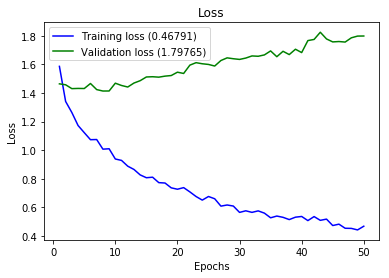

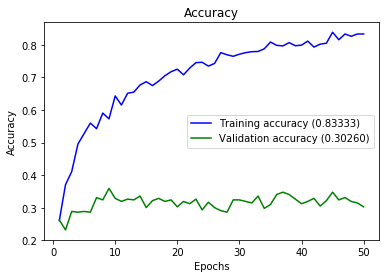

In [139]:
train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test 

trials, electrodes, timesteps = train_x.shape

# create model layers
model = Sequential([
    LSTM(100, return_sequences=False, input_shape=(electrodes, timesteps)),
    Dropout(0.5),
    Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y), callbacks=[es])
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

plot_history(history)

array([0.31602709, 0.34988713, 0.32731377, 0.3476298 , 0.35214447,
       0.33860045, 0.31376975, 0.3972912 , 0.34311512, 0.27990971])

Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 53s 31ms/step - loss: 2.0240 - acc: 0.2654 - val_loss: 1.5636 - val_acc: 0.3262
Epoch 2/50
1692/1692 [==============================] - 8s 5ms/step - loss: 1.5297 - acc: 0.3812 - val_loss: 1.5082 - val_acc: 0.3191
Epoch 3/50
1692/1692 [==============================] - 9s 5ms/step - loss: 1.3335 - acc: 0.4409 - val_loss: 1.4545 - val_acc: 0.3452
Epoch 4/50
1692/1692 [==============================] - 8s 5ms/step - loss: 1.1925 - acc: 0.4882 - val_loss: 1.4410 - val_acc: 0.3617
Epoch 5/50
1692/1692 [==============================] - 8s 4ms/step - loss: 1.0982 - acc: 0.5408 - val_loss: 1.4437 - val_acc: 0.3452
Epoch 6/50
1692/1692 [==============================] - 9s 5ms/step - loss: 1.0229 - acc: 0.5833 - val_loss: 1.4918 - val_acc: 0.3239
Epoch 7/50
1692/1692 [==============================] - 9s 5ms/step - loss: 0.9798 - acc: 0.5940 - val_loss: 1.4914 - val_acc: 0.3286
Epoch 8/50
16

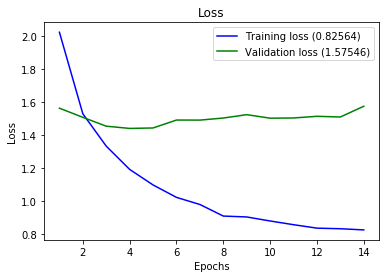

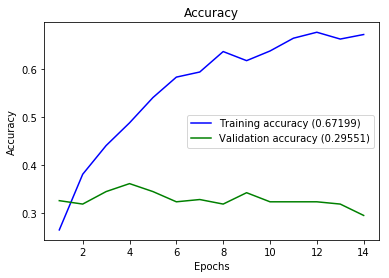

In [140]:
train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test 

trials, electrodes, timesteps = train_x.shape

# create model layers
model = Sequential([
    GRU(100, return_sequences=False, input_shape=(electrodes, timesteps)),
    Dropout(0.5),
    Dense(4, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=16, epochs=50, validation_data=(val_x, val_y), callbacks=[es])
score = model.evaluate(test_x, test_y, batch_size=16)
print(score)

plot_history(history)

Data transformed by <function scale_then_smooth at 0x0000029C3F0EA598>, scaling = minmax, optim = RMSprop, num_units = 50, stateful = False
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 157s 93ms/step - loss: 1.4931 - acc: 0.2476 - val_loss: 1.4443 - val_acc: 0.2719 9s - loss: 1.4950  - ETA: 4s - loss: 1.4944 -  - ETA: 3s - loss: 1.4944 -  - E
Epoch 2/50
1692/1692 [==============================] - 112s 66ms/step - loss: 1.3783 - acc: 0.3475 - val_loss: 1.4704 - val_acc: 0.3026 5s - loss: 1.3811 - acc: 0 - ETA: 4s - loss: 1.3812 - acc: 0 - ETA: 4s - - ETA: 0s - loss: 1.3763 - acc: 
Epoch 3/50
1692/1692 [==============================] - 115s 68ms/step - loss: 1.3415 - acc: 0.3859 - val_loss: 1.4008 - val_acc: 0.3499
Epoch 4/50
1692/1692 [==============================] - 112s 66ms/step - loss: 1.2490 - acc: 0.4663 - v

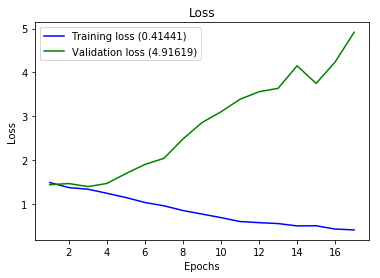

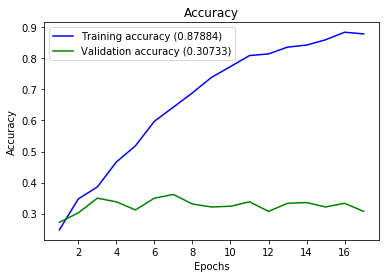

In [146]:
train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test 

trials, electrodes, timesteps = train_x.shape

# functions = [scale_then_smooth]
# scalings = ['minmax']
# optims = ['Adamax', 'RMSprop']
# num_units = [25, 50, 75]
# stateful = [True, False]

functions = [scale_then_smooth]
scalings = ['minmax']
optims = ['RMSprop']
num_units = [50]
stateful = [False]

best_acc = 0
best_optim = None
best_units = None
best_state = None

batch_size = 1

for state in stateful:
    for optim in optims:
        for scaling in scalings:
            for f in functions:
                for units in num_units:
                    print('Data transformed by {}, scaling = {}, optim = {}, num_units = {}, stateful = {}'
                          .format(f, scaling, optim, units, state))

                    try:
                        train = f(train_x, scaling)
                        val = f(val_x, scaling)
                        test = f(test_x, scaling)
                    except:
                        train = f(train_x)
                        val = f(val_x)
                        test = f(test_x)

                    model = Sequential()
                    model.add(GRU(units, return_sequences=True, stateful=state,
                                   batch_input_shape=(batch_size, electrodes, timesteps)))  
                    model.add(Dropout(0.5))
                    model.add(GRU(units, return_sequences=True, stateful=state)) 
                    model.add(Dropout(0.5))
                    model.add(GRU(units, stateful=state))
                    model.add(Dropout(0.5))
                    model.add(Dense(4, activation='softmax'))

                    model.compile(loss='sparse_categorical_crossentropy',
                                  optimizer='rmsprop',
                                  metrics=['accuracy'])
                    
                    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=50, validation_data=(val_x, val_y), callbacks=[es])                    
                    score = model.evaluate(test_x, test_y, batch_size=batch_size)
                    
                    print(score, score)

                    plot_history(history)


Data transformed by <function scale_then_smooth at 0x0000029C3F0EA598>, scaling = minmax, optim = RMSprop, num_units = 50, stateful = False
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Data scaled via minmax
Data smoothed.
Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 184s 109ms/step - loss: 1.4135 - acc: 0.2801 - val_loss: 1.3880 - val_acc: 0.2908
Epoch 2/50
1692/1692 [==============================] - 115s 68ms/step - loss: 1.3560 - acc: 0.3564 - val_loss: 1.3889 - val_acc: 0.3428
Epoch 3/50
1692/1692 [==============================] - 124s 73ms/step - loss: 1.1993 - acc: 0.4722 - val_loss: 1.5639 - val_acc: 0.2955
Epoch 4/50
1692/1692 [==============================] - 125s 74ms/step - loss: 1.0383 - acc: 0.5963 - val_loss: 1.9826 - val_acc: 0.3144
Epoch 5/50
1692/1692 [==============================] - 123s 73ms/step - loss: 0.8629 - acc: 0.7004 - val_loss: 1.9857 - val_acc: 0.3310
Epoch 6/50
16

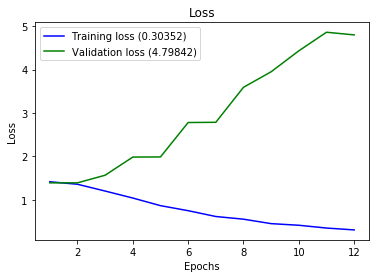

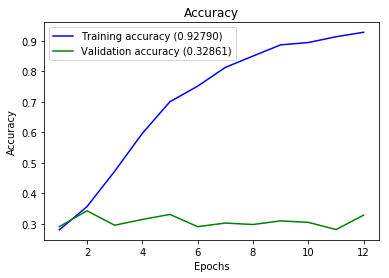

In [147]:
train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test 

trials, electrodes, timesteps = train_x.shape

# functions = [scale_then_smooth]
# scalings = ['minmax']
# optims = ['Adamax', 'RMSprop']
# num_units = [25, 50, 75]
# stateful = [True, False]

functions = [scale_then_smooth]
scalings = ['minmax']
optims = ['RMSprop']
num_units = [50]
stateful = [False]

best_acc = 0
best_optim = None
best_units = None
best_state = None

batch_size = 1

for state in stateful:
    for optim in optims:
        for scaling in scalings:
            for f in functions:
                for units in num_units:
                    print('Data transformed by {}, scaling = {}, optim = {}, num_units = {}, stateful = {}'
                          .format(f, scaling, optim, units, state))

                    try:
                        train = f(train_x, scaling)
                        val = f(val_x, scaling)
                        test = f(test_x, scaling)
                    except:
                        train = f(train_x)
                        val = f(val_x)
                        test = f(test_x)

                    model = Sequential()
                    model.add(LSTM(units, return_sequences=True, stateful=state,
                                   batch_input_shape=(batch_size, electrodes, timesteps)))  
                    model.add(Dropout(0.5))
                    model.add(LSTM(units, return_sequences=True, stateful=state)) 
                    model.add(Dropout(0.5))
                    model.add(LSTM(units, stateful=state))
                    model.add(Dropout(0.5))
                    model.add(Dense(4, activation='softmax'))

                    model.compile(loss='sparse_categorical_crossentropy',
                                  optimizer='rmsprop',
                                  metrics=['accuracy'])
                    
                    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=50, validation_data=(val_x, val_y), callbacks=[es])                    
                    score = model.evaluate(test_x, test_y, batch_size=batch_size)
                    
                    print(score)

                    plot_history(history)


In [148]:
loss

1.392241363264368

### Single LSTM comparison of data smoothing/scaling for ALL Subjects

In [218]:
functions = [scale_data, smooth_data, smooth_then_scale, scale_then_smooth]
trials, electrodes, time = X_train.shape

for f in functions:
    print('Data transformed by {}'.format(f))
    
    train = f(X_train)
    test = f(X_test)
    
    # create model layers
    model = Sequential([
        LSTM(100, return_sequences=False, input_shape=(electrodes, time)),
        Dropout(0.5),
        Dense(4, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(train, y_train, batch_size=16, epochs=10, verbose=0)
    score = model.evaluate(test, y_test, batch_size=16)
    print(score)

Data transformed by <function scale_data at 0x00000131F21DDB70>
443/443 [==============================] - 2s 5ms/step
[2.0054195123655263, 0.34311512442259434]
Data transformed by <function smooth_data at 0x00000131F24CEEA0>
443/443 [==============================] - 2s 5ms/step
[1.3774769220072314, 0.32505643381222105]
Data transformed by <function smooth_then_scale at 0x000001329F67D8C8>
443/443 [==============================] - 2s 5ms/step
[1.5836979140008276, 0.3318284427070187]
Data transformed by <function scale_then_smooth at 0x000001329F67D9D8>
443/443 [==============================] - 2s 5ms/step
[1.5346330519992666, 0.3882618512848968]


### Single LSTM Hyperopt

In [254]:
functions = [scale_data, smooth_data, smooth_then_scale, scale_then_smooth]
scalings = ['minmax', 'standard']
optims = ['adam', 'Nadam', 'Adamax', 'RMSprop']
trials, electrodes, time = X_train.shape

for optim in optims:
    for scaling in scalings:
        for f in functions:
            print('Data transformed by {}, scaling = {}, optim = {}'.format(f, scaling, optim))

            try:
                train = f(X_train, scaling)
                test = f(X_test, scaling)
            except:
                train = f(X_train)
                test = f(X_test)

            # create model layers
            model = Sequential([
                LSTM(100, return_sequences=False, input_shape=(electrodes, time)),
                Dropout(0.5),
                Dense(4, activation=tf.nn.softmax)
            ])

            model.compile(optimizer=optim,
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

            history = model.fit(train, y_train, batch_size=16, epochs=10, verbose=0)
            score = model.evaluate(test, y_test, batch_size=16)
            print(score)

Data transformed by <function scale_data at 0x000001330004F730>, scaling = minmax, optim = adam
443/443 [==============================] - 4s 8ms/step
[1.308409371171525, 0.3386004516690902]
Data transformed by <function smooth_data at 0x00000131F24CEEA0>, scaling = minmax, optim = adam
443/443 [==============================] - 4s 8ms/step
[1.4035635279748024, 0.3295711063639036]
Data transformed by <function smooth_then_scale at 0x000001329F67D8C8>, scaling = minmax, optim = adam
443/443 [==============================] - 4s 8ms/step
[1.3362518110339852, 0.35891647875712634]
Data transformed by <function scale_then_smooth at 0x000001329F67D9D8>, scaling = minmax, optim = adam
443/443 [==============================] - 4s 9ms/step: 
[1.3147049582569648, 0.3544018060708961]
Data transformed by <function scale_data at 0x000001330004F730>, scaling = standard, optim = adam
443/443 [==============================] - 4s 10ms/step
[2.014625542319924, 0.3386004517363641]
Data transformed by <

## Visualizations

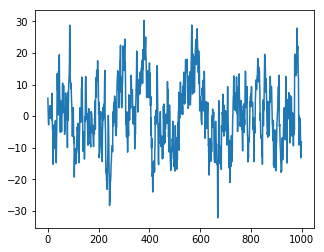

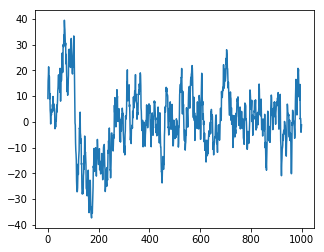

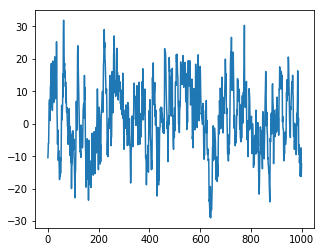

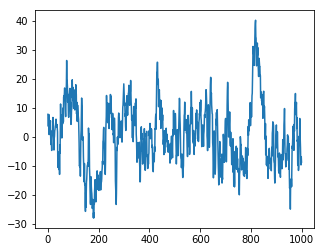

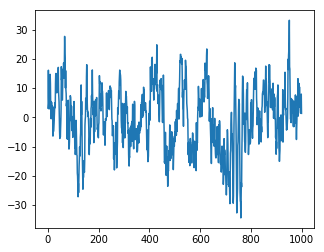

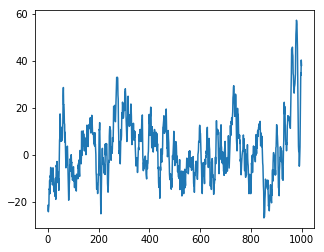

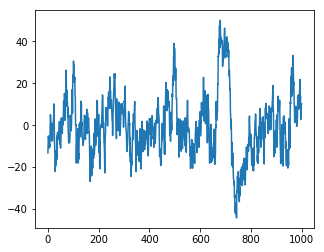

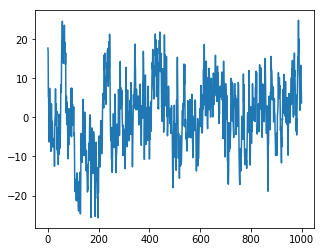

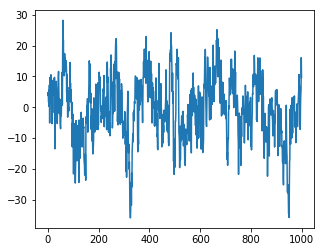

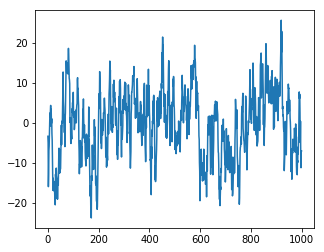

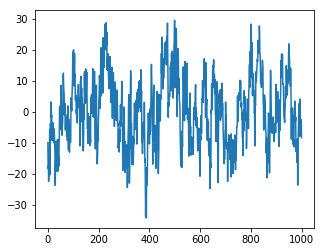

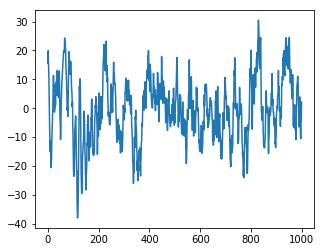

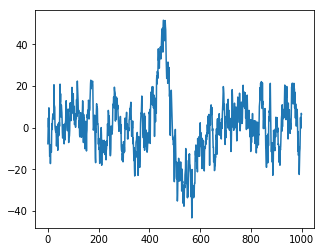

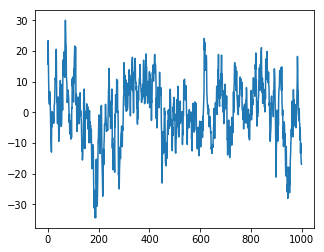

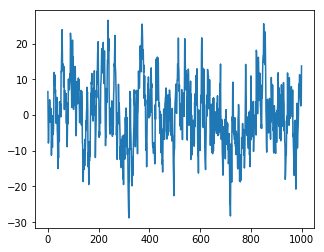

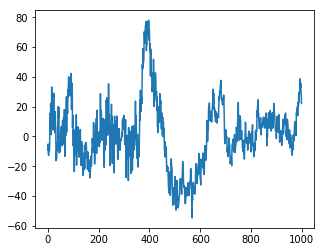

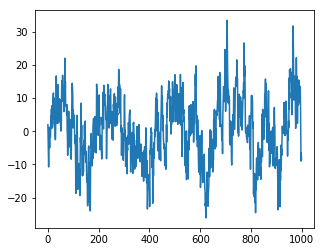

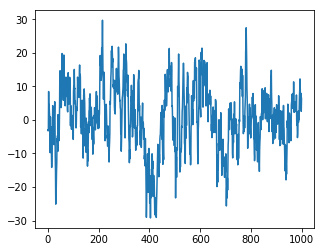

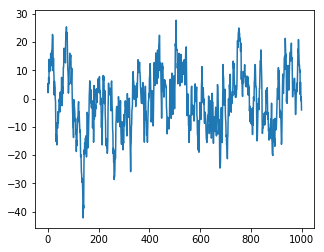

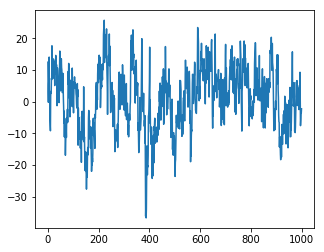

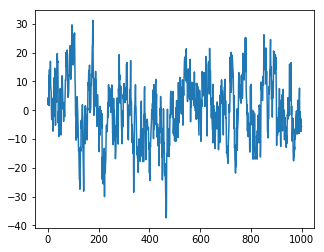

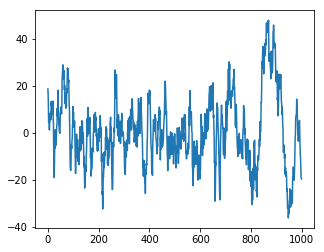

In [41]:
# ORIGINAL
for i in np.arange(X_train.shape[1]):
    plt.plot(np.arange(1000), X_train[i][0])
    plt.show()

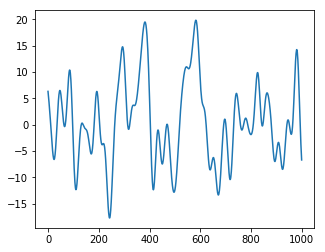

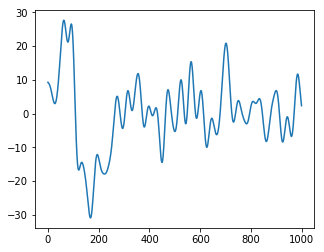

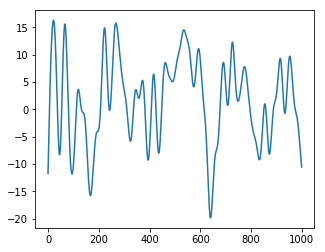

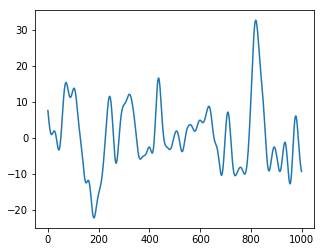

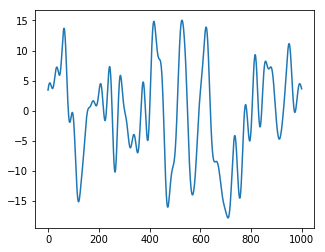

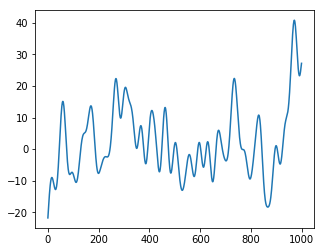

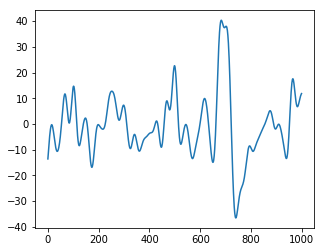

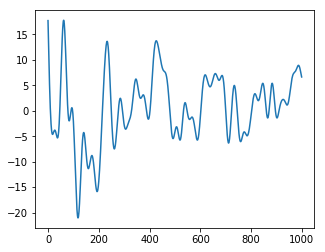

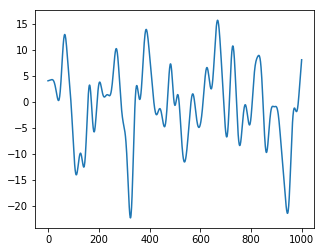

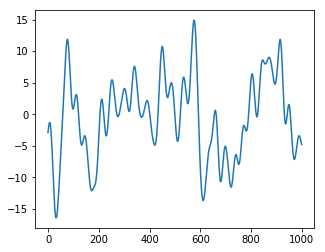

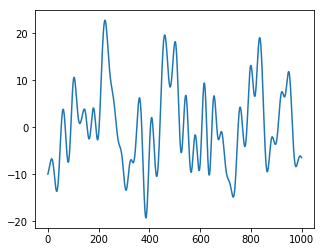

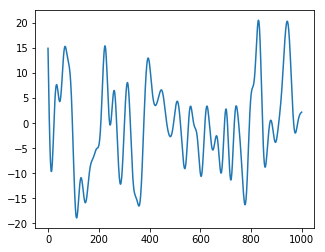

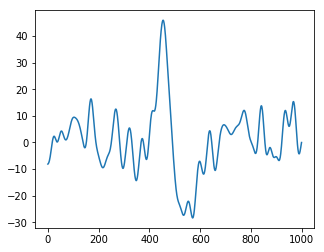

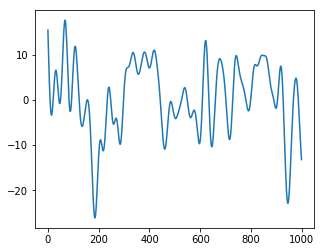

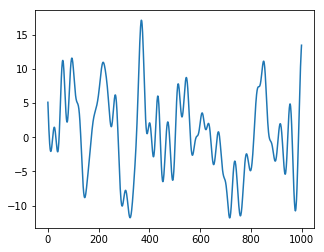

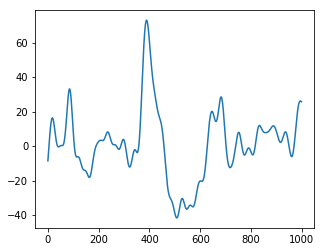

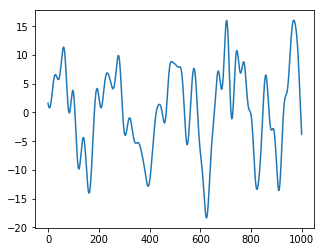

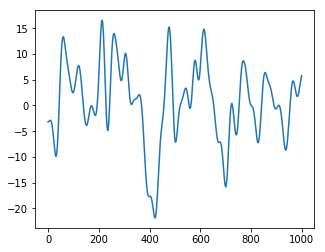

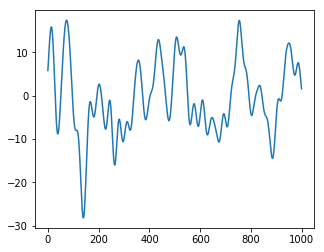

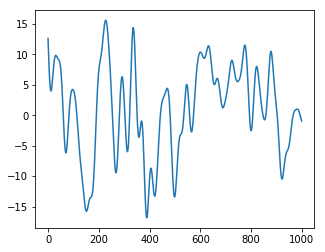

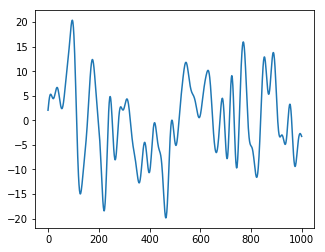

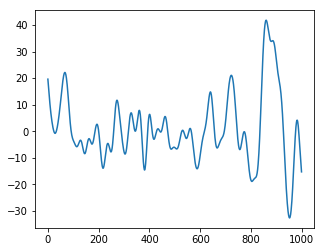

In [152]:
# SMOOTHED
X_train_smoothed = smooth_data(X_train)
for i in np.arange(X_train_smoothed.shape[1]):
    plt.plot(np.arange(1000), X_train_smoothed[i][0])
    plt.show()

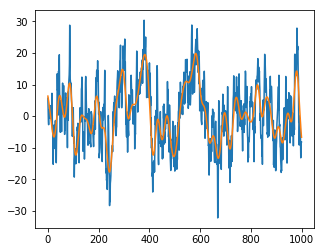

In [153]:
time = np.arange(X_train.shape[2])
eeg = X_train[0][0]
eeg_smooth = X_train_smoothed[0][0]

figure_pressure_trace = plt.figure()
figure_pressure_trace.clf()
plot_P_vs_t = plt.subplot(111)
plot_P_vs_t.plot(time, eeg)
plot_P_vs_t.plot(time, eeg_smooth)
plt.show()

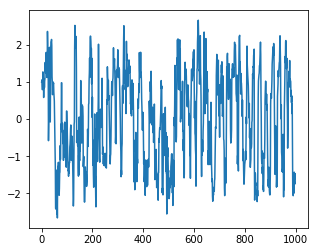

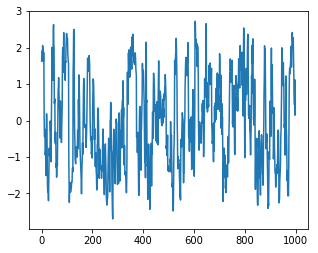

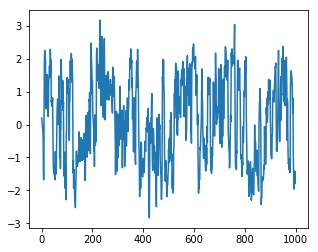

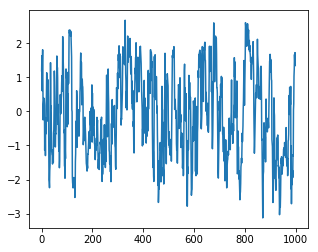

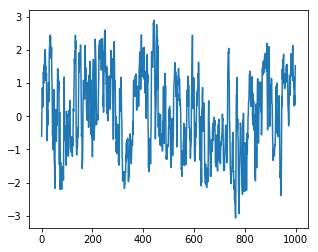

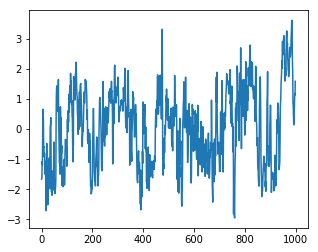

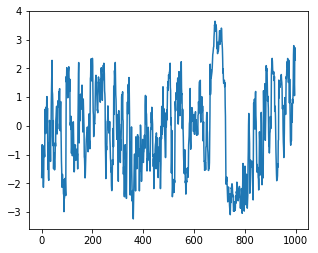

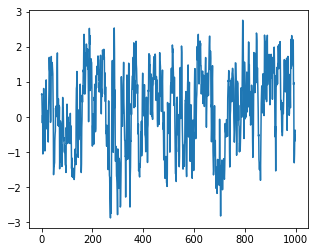

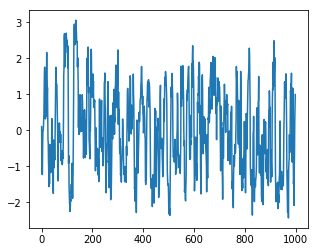

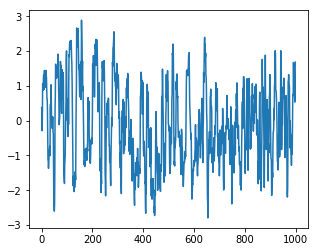

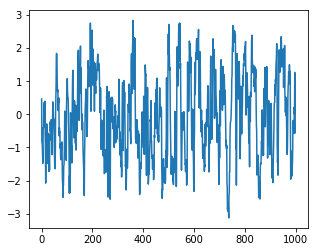

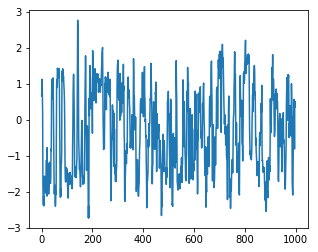

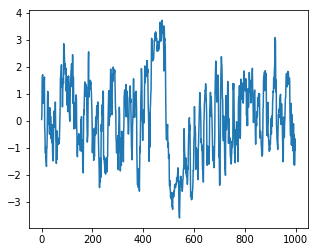

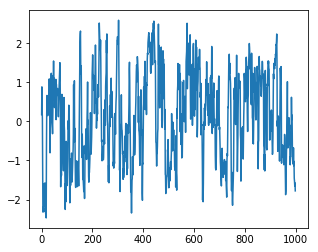

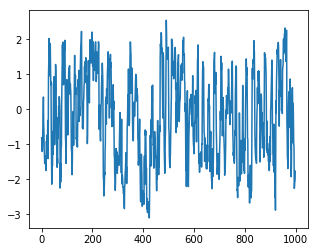

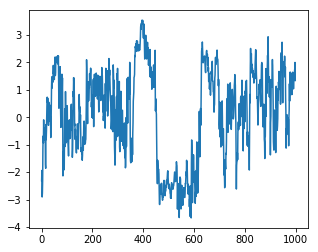

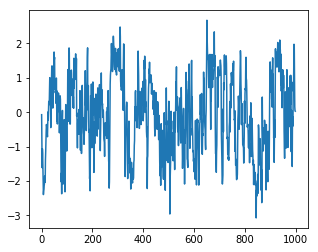

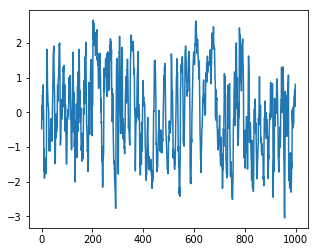

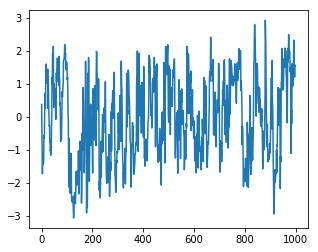

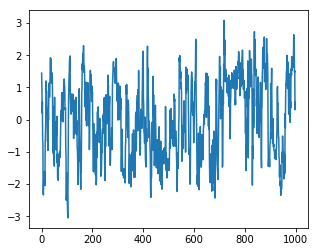

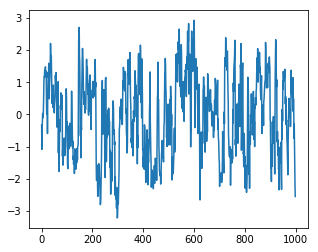

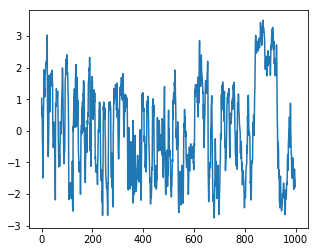

In [156]:
# SCALE
X_train_scaled = scale_data(X_train)
for i in np.arange(X_train.shape[1]):
    plt.plot(np.arange(1000), X_train_scaled[i][0])
    plt.show()

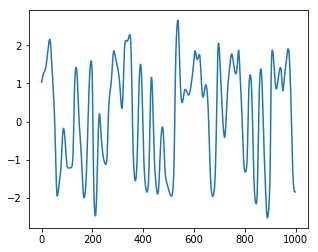

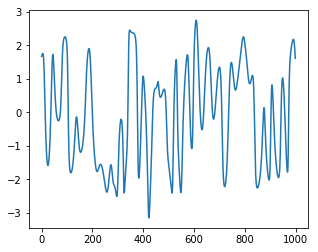

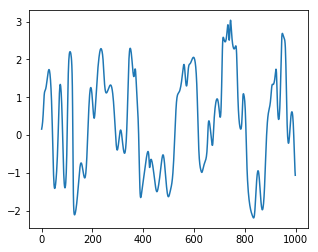

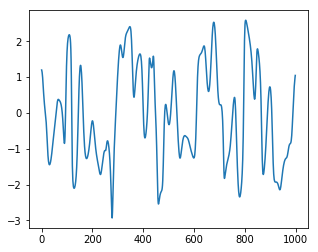

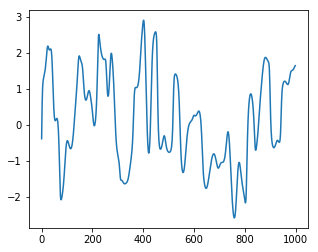

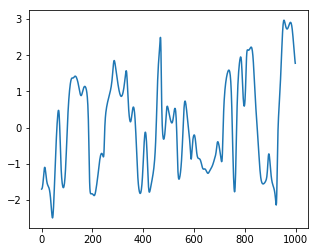

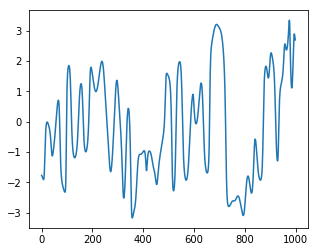

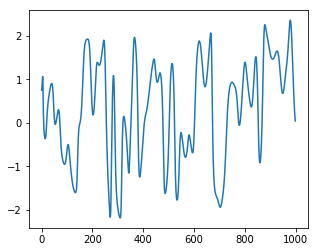

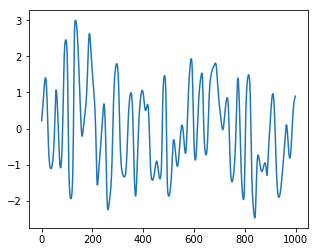

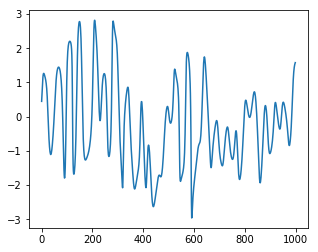

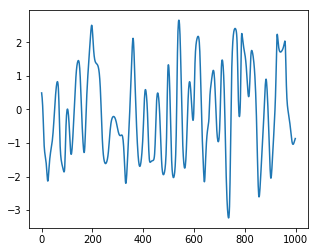

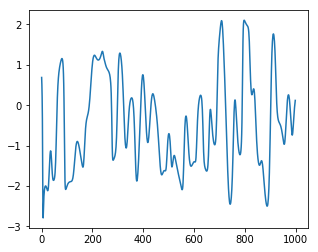

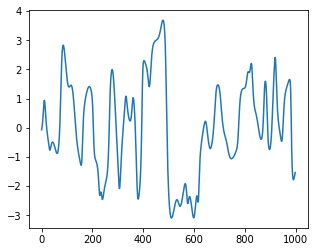

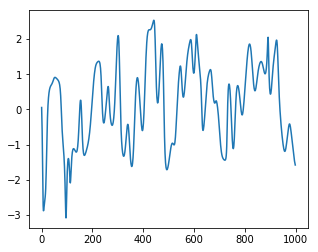

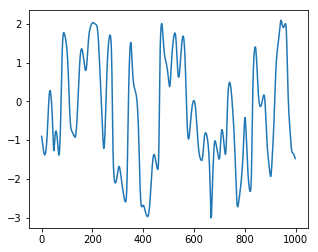

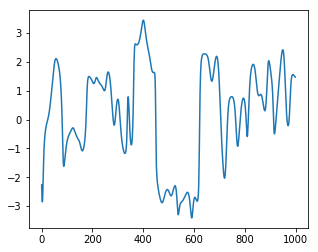

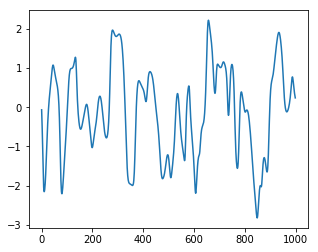

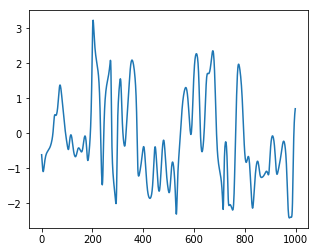

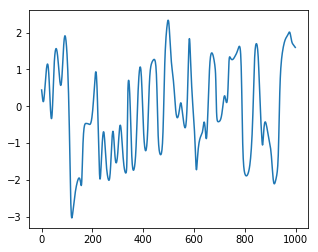

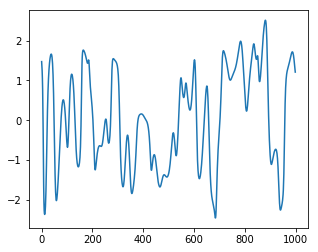

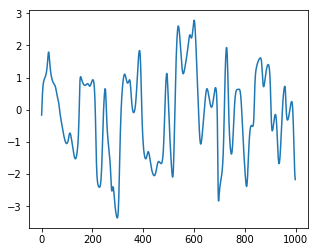

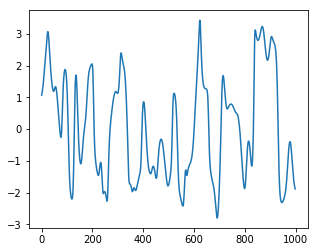

In [157]:
# SMOOTHED -> SCALE
X_train_scaled_smoothed = smooth_then_scale(X_train)
for i in np.arange(X_train.shape[1]):
    plt.plot(np.arange(1000), X_train_scaled[i][0])
    plt.show()

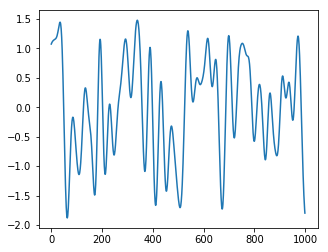

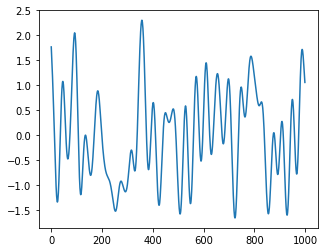

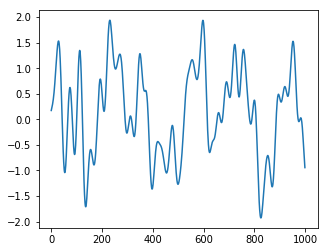

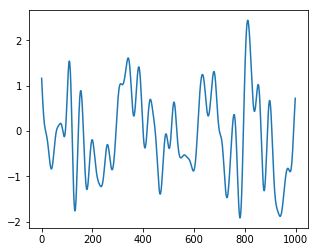

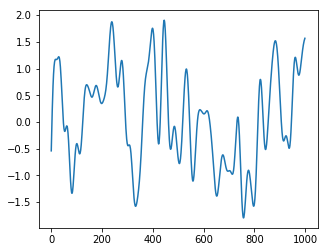

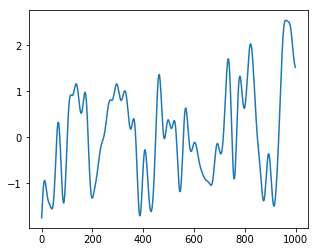

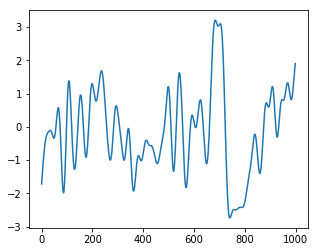

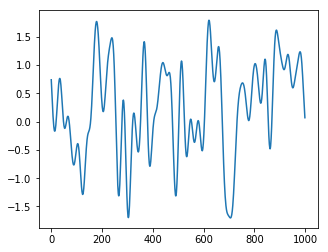

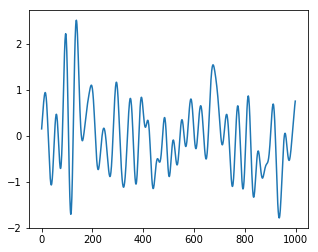

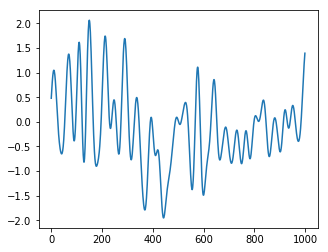

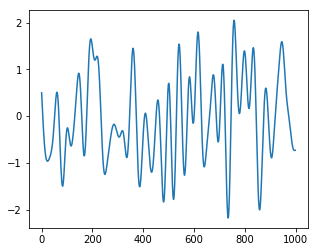

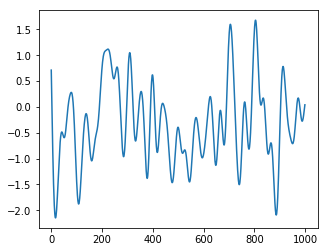

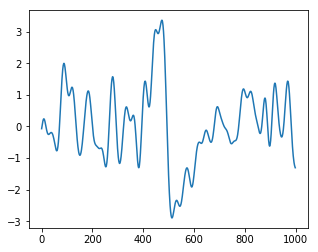

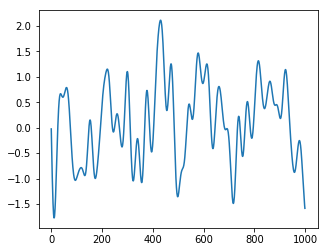

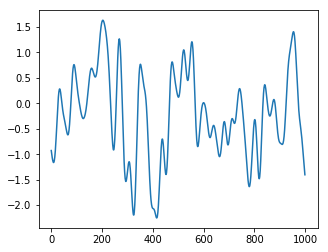

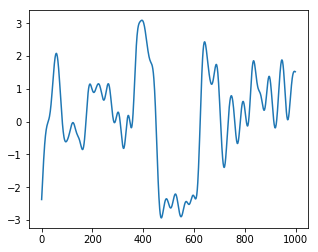

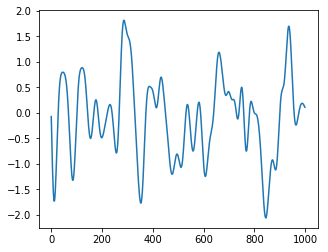

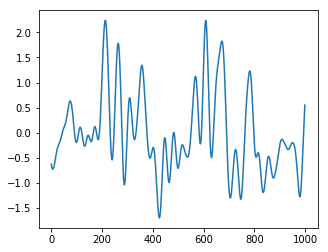

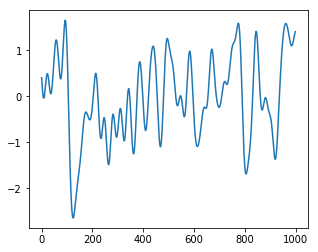

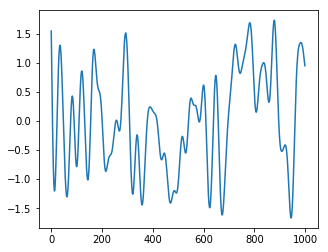

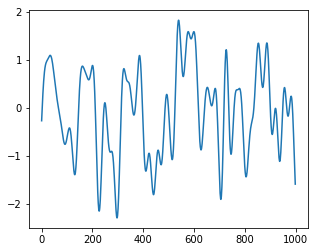

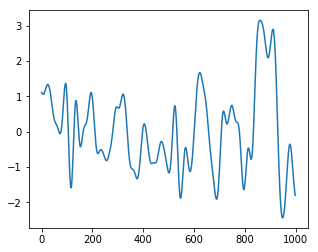

In [158]:
# SCALE -> SMOOTHED
X_train_smoothed_scaled = scale_then_smooth(X_train))
for i in np.arange(X_train.shape[1]):
    plt.plot(np.arange(1000), X_train_scaled[i][0])
    plt.show()